# fMRI Demo (premade patterns version)

## Introduction

This is an example of RSA on a BIDS-structured fMRI dataset. This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

Run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser, join
import json
import numpy, pandas
import matplotlib.pyplot as plt
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.rdm.rdms import concat
from rsatoolbox.vis.rdm_plot import show_rdm

Now we define the path to the BIDS-root data directory

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32/derivatives/nilearn')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
print('Loading..')
with open(join(data_dir, 'meta.json')) as fhandle:
    metadata = json.load(fhandle)
data = numpy.load(join(data_dir, 'data.npz'))

Loading..


In [6]:

subjects = metadata['subjects']
conditions = metadata['conditions']
dof = metadata['degrees_of_freedom']
N_RUNS = 6
subjects = ['07', '08', '09', '10', '11', '12', '13']
regions_of_interest = ['fusiform', 'lingual', 'lateraloccipital', 'inferiortemporal']

Let's repeat this for the other runs: (takes about 1min per run). Along the way we also store the MSE residuals for each run.

In [7]:
rdm_list = []
for region_name in regions_of_interest:
    for sub in subjects:
        print(f'roi {region_name} sub {sub}')

        betas = data[f'betas_sub-{sub}_{region_name}']
        patterns = betas.reshape(-1, betas.shape[-1])
        ds = Dataset(
            measurements=patterns,
            descriptors=dict(sub=sub, roi=region_name),
            obs_descriptors=dict(
                run=numpy.repeat(numpy.arange(N_RUNS), len(conditions)),
                condition=numpy.tile(conditions, N_RUNS)
            )
        )

        runwise_prec_matrix = []
        resids = data[f'resids_sub-{sub}_{region_name}']
        for r in range(N_RUNS):
            runwise_prec_matrix.append(
                prec_from_residuals(
                    resids[r, :, :],
                    dof=dof,
                    method='shrinkage_diag'
                )
            )

        rdm_list.append(
            calc_rdm(
                dataset=ds,
                noise=runwise_prec_matrix,
                method='crossnobis',
                descriptor='condition',
                cv_descriptor='run',
            )
        )
        #raise ValueError
        del rdm_list[-1].descriptors['noise']

roi fusiform sub 07
roi fusiform sub 08
roi fusiform sub 09
roi fusiform sub 10
roi fusiform sub 11
roi fusiform sub 12
roi fusiform sub 13
roi lingual sub 07
roi lingual sub 08
roi lingual sub 09
roi lingual sub 10
roi lingual sub 11
roi lingual sub 12
roi lingual sub 13
roi lateraloccipital sub 07
roi lateraloccipital sub 08
roi lateraloccipital sub 09
roi lateraloccipital sub 10
roi lateraloccipital sub 11
roi lateraloccipital sub 12
roi lateraloccipital sub 13
roi inferiortemporal sub 07
roi inferiortemporal sub 08
roi inferiortemporal sub 09
roi inferiortemporal sub 10
roi inferiortemporal sub 11
roi inferiortemporal sub 12
roi inferiortemporal sub 13


In [8]:
data_rdms = concat(rdm_list)

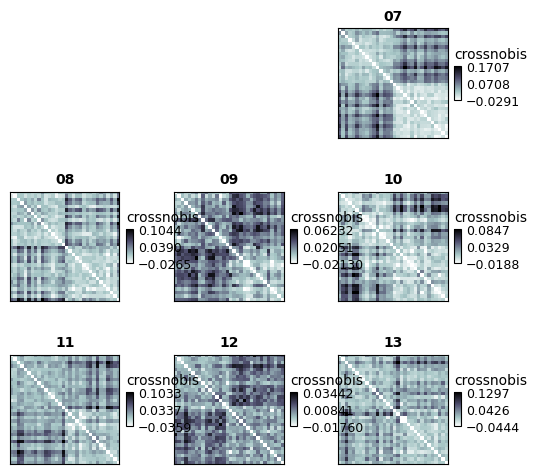

In [9]:
fusiform_rdms = data_rdms.subset('roi', 'fusiform')
fig, _, _ = show_rdm(
    fusiform_rdms,
    rdm_descriptor='sub',
    show_colorbar='panel'
)
plt.show()

## Model

Let's map the various stimulus properties of interest on a table

In [11]:
INDOOR = ['bagel', 'candle', 'clock', 'glass', 'kettle', 'knife', 'sponge', 'table']
STRAIGHT = ['candle', 'knife', 'sponge', 'table', 'spade', 'ladder', 'brick', 'pedal']
df = pandas.DataFrame([dict(
    trial_type=c,
    indoor=float(c.split('_')[1] in INDOOR),
    straight=float(c.split('_')[1] in STRAIGHT),
    modality=float('image_' in c)
) for c in conditions])
df.sample(5)

,trial_type,indoor,straight,modality
2,image_candle,1.0,1.0,1.0
21,text_glove,0.0,0.0,0.0
6,image_helmet,0.0,0.0,1.0
13,image_sponge,1.0,1.0,1.0
11,image_saddle,0.0,0.0,1.0


We can then turn these into Model RDMs

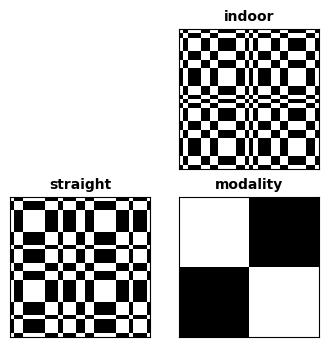

In [12]:
model_dataset = Dataset.from_df(df)
model_dataset.channel_descriptors
model_rdms = calc_rdm(
    [model_dataset.split_channel('name')],
    method='euclidean',
    descriptor='trial_type'
)
model_rdms.rdm_descriptors['name'] = model_dataset.channel_descriptors['name']
fig, _, _ = show_rdm(model_rdms, rdm_descriptor='name')
plt.show()

Next, we wrap each of the model RDMs in their own fixed `Model` object.

In [13]:
from rsatoolbox.model.model import ModelFixed

models = []
for model_name in model_rdms.rdm_descriptors['name']:
    model_rdm = model_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))

## Inference

Let's see how well each of these models explains the fMRI data RDMs

In [14]:
from rsatoolbox.inference.evaluate import eval_dual_bootstrap

eval_result = eval_dual_bootstrap(models, fusiform_rdms)
print(eval_result)

100%|██████████| 1000/1000 [00:04<00:00, 214.48it/s]

Results for running dual_bootstrap evaluation for cosine on 3 models:

Model    |   Eval ± SEM   | p (against 0) | p (against NC) |
------------------------------------------------------------
indoor   |  0.388 ± 0.035 |      < 0.001  |       < 0.001  |
straight |  0.388 ± 0.037 |      < 0.001  |       < 0.001  |
modality |  0.683 ± 0.047 |      < 0.001  |         0.225  |

p-values are based on uncorrected t-tests


Next let's plot a comparison of the models:

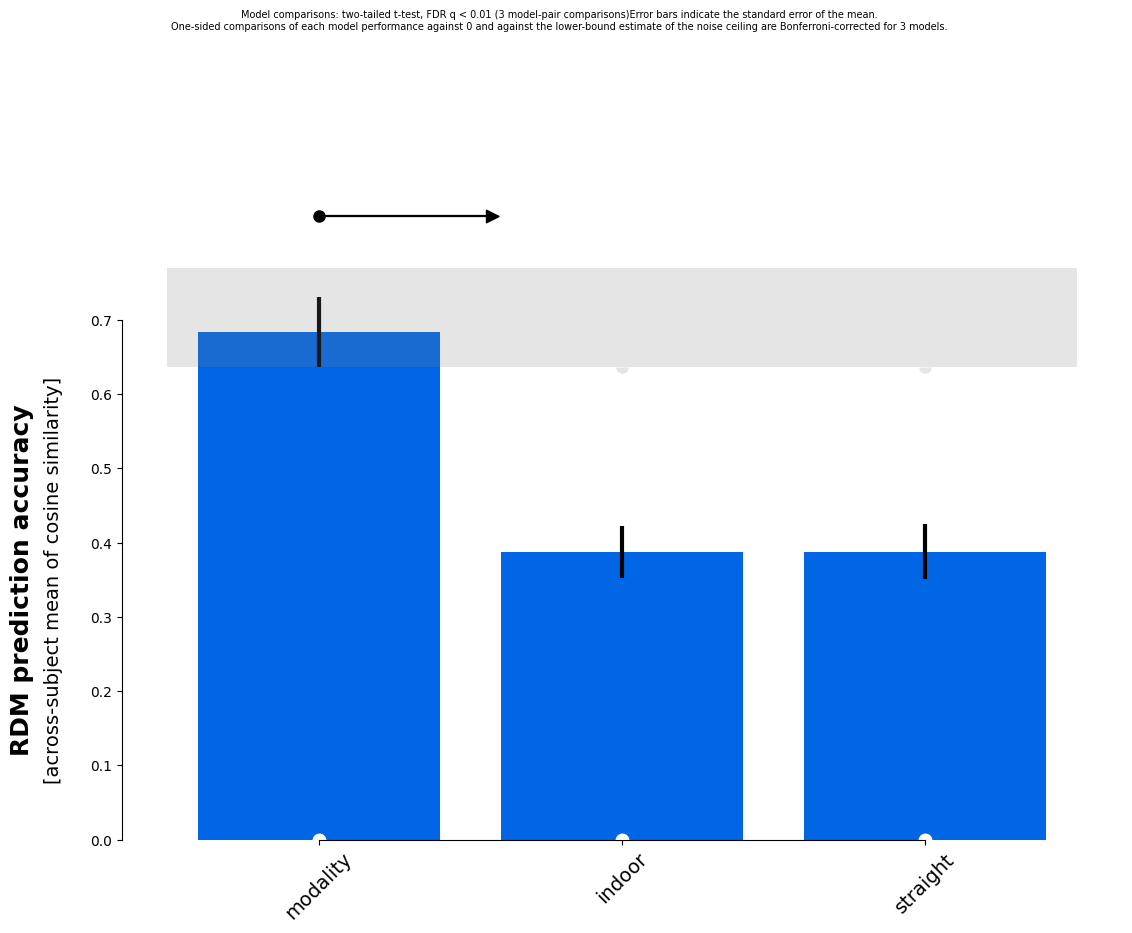

In [15]:
from rsatoolbox.vis.model_plot import plot_model_comparison

fig, _, _ = plot_model_comparison(eval_result, sort=True)
plt.show()